## Chinese Word Segmentation (I)--dictionary method 

### As I introduced in presentation, word segmentation in Chinese is a challenge. My project is to compare different methods of doing that task. Here is the first solution I would like to introduce.

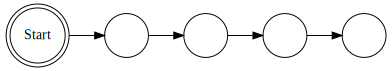

In [7]:
import graphviz
#model.insert("赫尔辛基") 赫尔辛基=Helsinki
f = graphviz.Digraph()
f.attr(rankdir='LR', size='8,8')
f.attr('node', shape='doublecircle')
#f.node('q0')
f.node('Start')
f.attr('node', shape='circle')
f.edge('Start', '赫')
f.edge('赫', '尔', )
f.edge('尔', '辛')
f.edge('辛', '基')
f

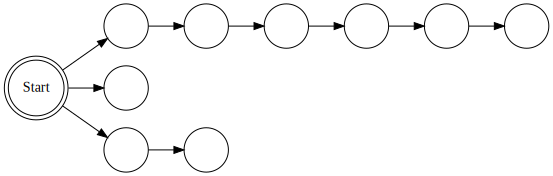

In [8]:
f.edge('基', '大')  #  大学=university
f.edge('大', '学')
f.edge('Start','在')
f.edge('Start','芬')
f.edge('芬', '兰')
f

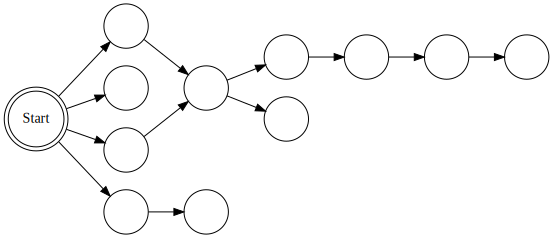

In [10]:
f.edge('Start', '图')  # 图尔库=Turku
f.edge('图', '尔')
f.edge('尔', '库')
f

### So in this way, we insert all known words into the dictionary and when we encounter a sentence, we just check if the character can be a known word, if yes, we separate it. If not, we leave it alone. 

### We also have a strategy named Maximum Matching, meaning we always want to include all possible substrings.
### For example, if we encounter "赫尔辛基大学在芬兰"(The university of Helsinki is in Finland), the model will regard "赫尔辛基大学" as a word instead of "赫尔辛基"

In [1]:
with open(r'./training_and_testing_data/pku_training.txt',encoding='gbk') as f:# the path may need change
    content=f.readlines()
content="".join(content).strip()
#content=re.sub("。|？|！|\n","<end>",content)
content=content.split("\n")
while '  ' in content:
    content.remove('  ')
while '' in content:
    content.remove('')
for i,sentence in enumerate(content):
    content[i]=content[i].strip()
training_text='  '.join(content).split("  ")

In [2]:
len(training_text)

1109947

In [3]:
#longest match
import re
class Dict_Trie():
    def __init__(self):
        self.root={}
        self.end=True
        
    def insert(self,word):
        curr_node=self.root
        for char in word:
            if not char in curr_node:
                curr_node[char]={}
            curr_node=curr_node[char]
        curr_node['status']=True
        
    def search(self,word):#search if a word is collected in the dictionary
        curr_node=self.root
        for char in word:
            if not char in curr_node:
                return False
            curr_node=curr_node[char]
        if curr_node.get('status')==True:
            return True
        else:
            return False
        
    def check_prefix(self,word):
        curr_node=self.root
        for char in word:
            if not char in curr_node:
                return False
            curr_node=curr_node[char]
        return True
    
    def forward_maximum_return(self,words):
        max_index=0
        for length, word in enumerate(words):
            if self.search(words[:length+1]):
                max_index=length
            if not self.check_prefix(words[:length+2]):
                #if the following character still exists in the path,keep searching,if not,directly return 
                break
        return max_index
    
    def backward_maximum_return(self, words):# basically the same as forward one, but it start search from the end
        max_index=len(words)
        for start in range(0,max_index):
            if self.search(words[start:max_index+1]):
                return start
        return start
    
    def seg_forw(self,sentence):
        segments=[]
        while len(sentence) != 0:
            cut_point=self.forward_maximum_return(sentence)+1
            word=sentence[:cut_point]
            segments.append(word)
            sentence=sentence[cut_point:]
        return '  '.join(segments)
    
    def seg_back(self,sentence):
        segments=[]
        while len(sentence) != 0:
            cut_point=self.backward_maximum_return(sentence)
            word=sentence[cut_point:]
            segments.append(word)
            sentence=sentence[:cut_point]
        return '  '.join(segments[::-1])
# what's the case for OOV? only return as a single character
model=Dict_Trie()
for word in training_text:
    model.insert(word)

In [6]:
print(model.seg_forw('研究生命的起源。'))#研究investigate, 生命life, 研究生 graduate(student)，命 life/fate, 的 ’s, 起源 origin
print(model.seg_back('研究生命的起源。'))#difference between forward and backward maximum matching

研究生  命  的  起源  。
研究  生命  的  起源  。


In [8]:
with open(r'./training_and_testing_data/pku_test.txt',encoding='gbk') as f:# the path may need change
    test=f.readlines()
for i,s in enumerate(test):
    test[i]=model.seg(s)
with open('pku_test_segmentation_d.txt',"a") as f:
    f.writelines(test)